In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/airplane-accidents-severity-dataset/sample_submission.csv
/kaggle/input/airplane-accidents-severity-dataset/train.csv
/kaggle/input/airplane-accidents-severity-dataset/test.csv


## Reading the given dataset

In [2]:
train_df = pd.read_csv('/kaggle/input/airplane-accidents-severity-dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/airplane-accidents-severity-dataset/test.csv')
sample_sub_df = pd.read_csv('/kaggle/input/airplane-accidents-severity-dataset/sample_submission.csv')

## Highlights of the dataset

<pre>
Accident_ID:              	unique id assigned to each row
Accident_Type_Code:     	  the type of accident (factor, not numeric)
Cabin_Temperature:      	  the last recorded temperature before the incident, measured in degrees fahrenheit
Turbulence_In_gforces:	    the recorded/estimated turbulence experienced during the accident
Control_Metric:               an estimation of how much control the pilot had during the incident given the factors at play
Total_Safety_Complaints: 	 number of complaints from mechanics prior to the accident
Days_Since_Inspection:  	  how long the plane went without inspection before the incident
Safety_Score:           	  a measure of how safe the plane was deemed to be
Severity:	                 a description (4 level factor) on the severity of the crash [Target]
</pre>

In [3]:
train_df.head()

,Severity,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,Minor_Damage_And_Injuries,49.223744,14,22,71.285324,0.272118,78.04,2,31335.476824,3,0.424352,7570
1,Minor_Damage_And_Injuries,62.465753,10,27,72.288058,0.423939,84.54,2,26024.711057,2,0.352350,12128
2,Significant_Damage_And_Fatalities,63.059361,13,16,66.362808,0.322604,78.86,7,39269.053927,3,0.003364,2181
3,Significant_Damage_And_Serious_Injuries,48.082192,11,9,74.703737,0.337029,81.79,3,42771.499200,1,0.211728,5946
4,Significant_Damage_And_Fatalities,26.484018,13,25,47.948952,0.541140,77.16,3,35509.228515,2,0.176883,9054


In [4]:
test_df.head()

,Safety_Score,Days_Since_Inspection,Total_Safety_Complaints,Control_Metric,Turbulence_In_gforces,Cabin_Temperature,Accident_Type_Code,Max_Elevation,Violations,Adverse_Weather_Metric,Accident_ID
0,19.497717,16,6,72.151322,0.388959,78.32,4,37949.724386,2,0.069692,1
1,58.173516,15,3,64.585232,0.250841,78.60,7,30194.805567,2,0.002777,10
2,33.287671,15,3,64.721969,0.336669,86.96,6,17572.925484,1,0.004316,14
3,3.287671,21,5,66.362808,0.421775,80.86,3,40209.186341,2,0.199990,17
4,10.867580,18,2,56.107566,0.313228,79.22,2,35495.525408,2,0.483696,21


In [5]:
sample_sub_df.head()

,Accident_ID,Severity
0,1,Minor_Damage_And_Injuries
1,10,Highly_Fatal_And_Damaging
2,14,Highly_Fatal_And_Damaging
3,17,Significant_Damage_And_Serious_Injuries
4,21,Minor_Damage_And_Injuries


In [6]:
print(f'Shape of training data: {train_df.shape}')
print(f'Shape of testing data: {test_df.shape}')

Shape of training data: (10000, 12)
Shape of testing data: (2500, 11)


## Analysis of missing values (NaNs)

In [7]:
train_df.isna().sum()

Severity                   0
Safety_Score               0
Days_Since_Inspection      0
Total_Safety_Complaints    0
Control_Metric             0
Turbulence_In_gforces      0
Cabin_Temperature          0
Accident_Type_Code         0
Max_Elevation              0
Violations                 0
Adverse_Weather_Metric     0
Accident_ID                0
dtype: int64

In [8]:
test_df.isna().sum()

Safety_Score               0
Days_Since_Inspection      0
Total_Safety_Complaints    0
Control_Metric             0
Turbulence_In_gforces      0
Cabin_Temperature          0
Accident_Type_Code         0
Max_Elevation              0
Violations                 0
Adverse_Weather_Metric     0
Accident_ID                0
dtype: int64

So there are no missing values in the dataset.

## Exploratory Data Analysis

In [9]:
X_train = train_df.drop(['Severity', 'Accident_ID'], axis=1)
Y_train = train_df['Severity']

In [10]:
Y_train.unique()

array(['Minor_Damage_And_Injuries', 'Significant_Damage_And_Fatalities',
       'Significant_Damage_And_Serious_Injuries',
       'Highly_Fatal_And_Damaging'], dtype=object)

So there are 4 classes of accidents (out target variable). Let's map those classes to integers

In [11]:
class_map = {
    'Minor_Damage_And_Injuries': 0,
    'Significant_Damage_And_Fatalities': 1,
    'Significant_Damage_And_Serious_Injuries': 2,
    'Highly_Fatal_And_Damaging': 3
}
inverse_class_map = {
    0: 'Minor_Damage_And_Injuries',
    1: 'Significant_Damage_And_Fatalities',
    2: 'Significant_Damage_And_Serious_Injuries',
    3: 'Highly_Fatal_And_Damaging'
}

In [12]:
Y_train = Y_train.map(class_map).astype(np.uint8)

### 1. Distribution of Target Variable 

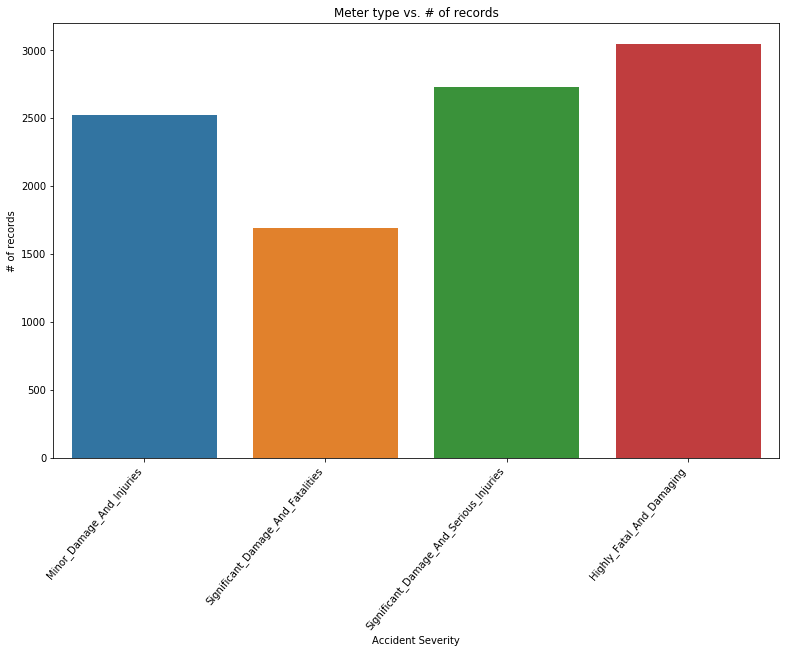

In [13]:
plt.figure(figsize=(13,8))
ax = sns.barplot(np.vectorize(inverse_class_map.get)(pd.unique(Y_train)), Y_train.value_counts().sort_index())
ax.set(xlabel='Accident Severity', ylabel='# of records', title='Meter type vs. # of records')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

### 2. Distribution of safety score

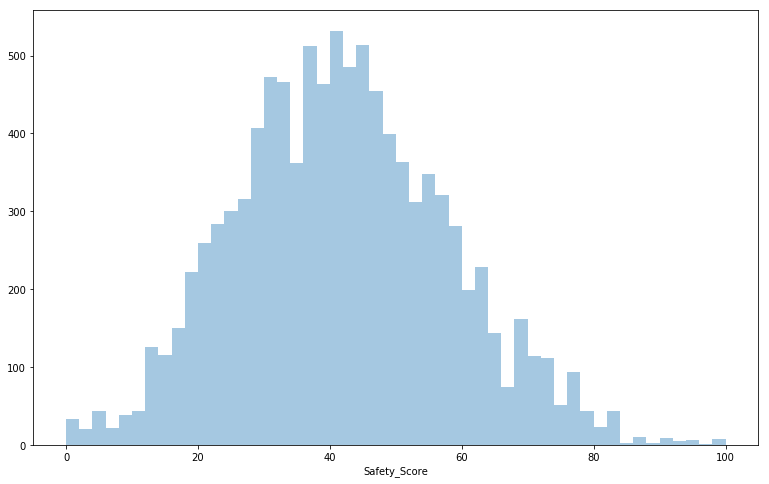

In [14]:
plt.figure(figsize=(13,8))
sns.distplot(X_train['Safety_Score'], kde=False)
plt.show()

### 3. Distribution of days till Last inspection

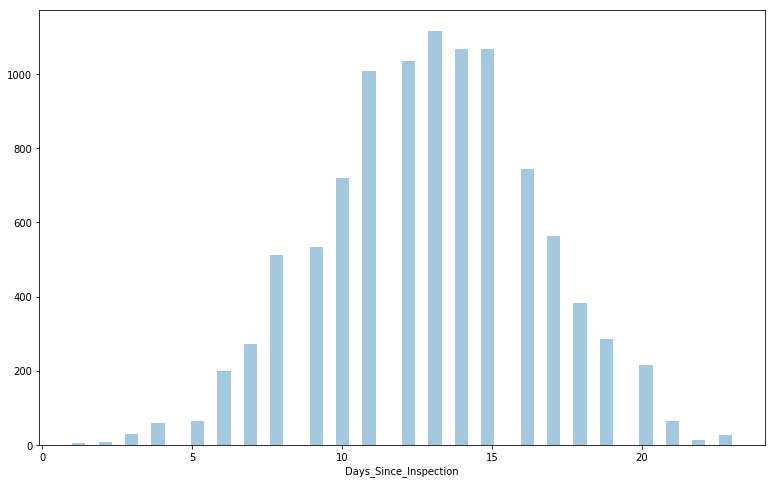

In [15]:
plt.figure(figsize=(13,8))
sns.distplot(X_train['Days_Since_Inspection'], kde=False)
plt.show()

### 3. Distribution of total safety complaints

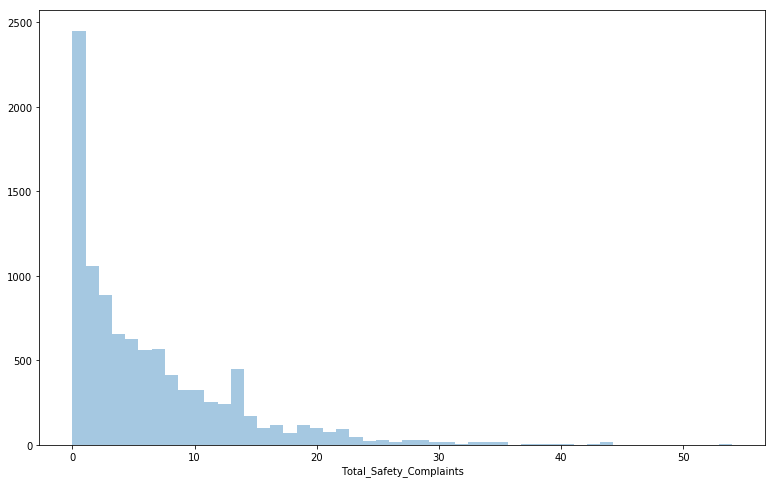

In [16]:
plt.figure(figsize=(13,8))
sns.distplot(X_train['Total_Safety_Complaints'], kde=False)
plt.show()

### 4. Distribution of control metric

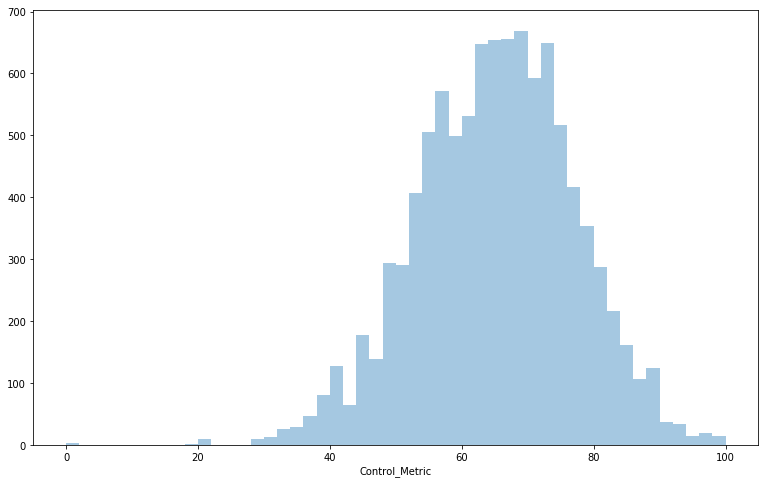

In [17]:
plt.figure(figsize=(13,8))
sns.distplot(X_train['Control_Metric'], kde=False)
plt.show()

### 5. Distribution of Turbulence

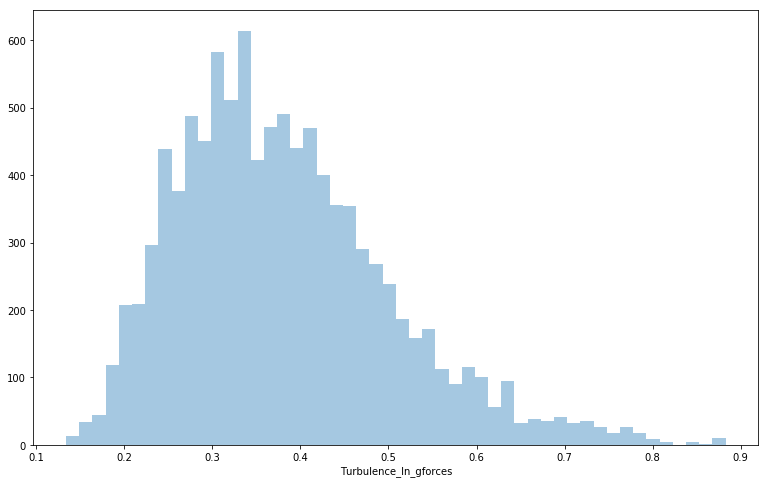

In [18]:
plt.figure(figsize=(13,8))
sns.distplot(X_train['Turbulence_In_gforces'], kde=False)
plt.show()

### 6. Distribution of Cabin Temperature (deg. F)

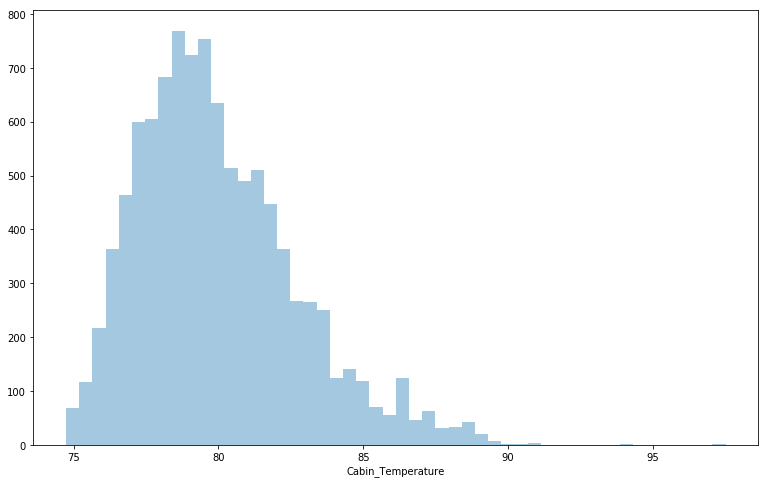

In [19]:
plt.figure(figsize=(13,8))
sns.distplot(X_train['Cabin_Temperature'], kde=False)
plt.show()

### 7. Distribution of Max Elevation

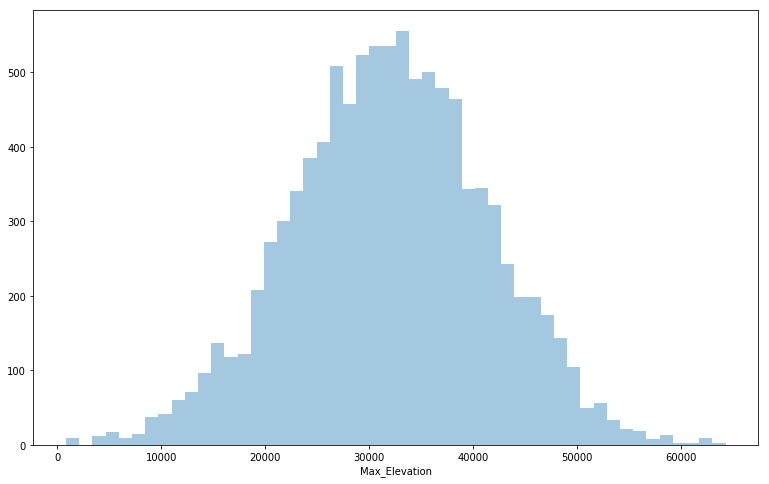

In [20]:
plt.figure(figsize=(13,8))
sns.distplot(X_train['Max_Elevation'], kde=False)
plt.show()

### 8. Distribution of number of violations

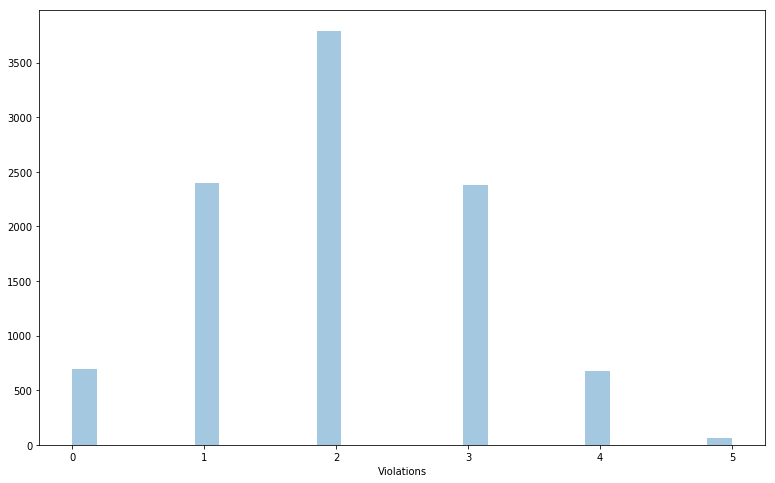

In [21]:
plt.figure(figsize=(13,8))
sns.distplot(X_train['Violations'], kde=False)
plt.show()

### 9. Distribution of adverse weather metric

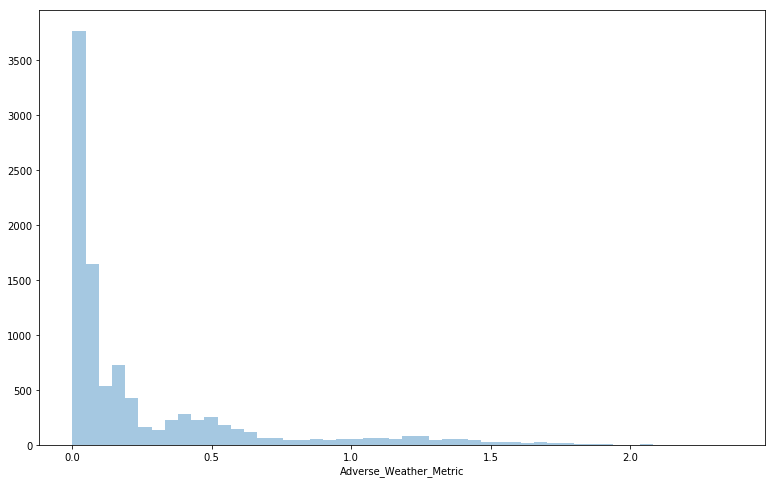

In [22]:
plt.figure(figsize=(13,8))
sns.distplot(X_train['Adverse_Weather_Metric'], kde=False)
plt.show()

In [23]:
X_train['Total_Safety_Complaints'] = np.power(2, X_train['Total_Safety_Complaints'])
X_train['Days_Since_Inspection'] = np.power(2, X_train['Days_Since_Inspection'])
X_train['Safety_Score'] = np.power(2, X_train['Safety_Score'])

In [24]:
rf = RandomForestClassifier(n_estimators=1250, random_state=666, oob_score=True)

# 0.8589427
param_grid = { 
    'n_estimators': [1000],
    'max_features': [None],
    'min_samples_split': [3],
    'max_depth': [50]
    
}

CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=6, verbose=100, n_jobs=-1)
CV_rf.fit(X_train, Y_train)
print (f'Best Parameters: {CV_rf.best_params_}')

Fitting 6 folds for each of 1 candidates, totalling 6 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Pickling array (shape=(10,), dtype=object).
Pickling array (shape=(6, 10000), dtype=float64).
Pickling array (shape=(4, 10000), dtype=int64).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(4,), dtype=object).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(4,), dtype=int64).
Pickling array (shape=(10000,), dtype=uint8).
Pickling array (shape=(8331,), dtype=int64).
Pickling array (shape=(1669,), dtype=int64).
Pickling array (shape=(10,), dtype=object).
Pickling array (shape=(6, 10000), dtype=float64).
Pickling array (shape=(4, 10000), dtype=int64).
Pickling array (shape=(6,), dtype=object).
Pickling array (shape=(4,), dtype=object).
Pickling array (shape=(6,), dtype=int64).
Pickling array (shape=(4,), dtype=int64).
Pickling array (shape=(10000,), dtype=uint8).
Pickling array (shape=(8333,), dtype=int64).
Pickling array

In [25]:
test_df['Total_Safety_Complaints'] = np.power(2, test_df['Total_Safety_Complaints'])
test_df['Days_Since_Inspection'] = np.power(2, test_df['Days_Since_Inspection'])
test_df['Safety_Score'] = np.power(2, test_df['Safety_Score'])

In [26]:
preds = CV_rf.predict(test_df.drop(['Accident_ID'], axis=1))

In [27]:
submission = pd.DataFrame([test_df['Accident_ID'], np.vectorize(inverse_class_map.get)(preds)], index=['Accident_ID', 'Severity']).T
submission.to_csv('submission.csv', index=False)
submission.head()

,Accident_ID,Severity
0,1,Highly_Fatal_And_Damaging
1,10,Significant_Damage_And_Fatalities
2,14,Significant_Damage_And_Serious_Injuries
3,17,Highly_Fatal_And_Damaging
4,21,Significant_Damage_And_Fatalities


In [28]:
from IPython.display import FileLink, FileLinks

FileLink('submission.csv')

/kaggle/working/submission.csv